Chargement de la base de donnée session8.db


In [3]:
!pip install mplfinance

     |████████████████████████████████| 51kB 1.7MB/s 


In [4]:
import pandas as pd # chargement des bases de donnees
import sqlite3  # chargement/ ecriture dans les bases de donnees

import requests # chargement des donnees depuis l'API
from requests import get #

import pprint #

import os.path #lire des fichiers
if not os.path.isfile("session8.db"):      
    import urllib.request #telecharger un fichier depuis une url
    urllib.request.urlretrieve("http://homepages.ulb.ac.be/~choffreu/session8.db", "session8.db")#telechargement du fichier depuis lurl specifie sous le nom de session8.db

SESSION8 = sqlite3.connect('session8.db') #creation de la connexion avec la BDD (rouge)
cursor_SESSION8 = SESSION8.cursor() 

liste_tickers='"GOOGL","AAPL","FB","AMZN","MSFT","CHIK","BSCP","MHD","LABU","AUSF"'     #création de la liste contenant les tickers
query = '''
  SELECT name, gsector, ticker
  FROM Companies 
  WHERE ticker IN ('''+liste_tickers+')'             #selectionner les données "name" "gsector" et nom du "ticker" depuis 
 
information_from_session8 = pd.read_sql_query(query,SESSION8) 

print(information_from_session8)







                           name                     gsector ticker
0                  ALPHABET INC  Telecommunication Services  GOOGL
1                  FACEBOOK INC  Telecommunication Services     FB
2    GLOBAL X MSCI CHINA IT ETF                         N/A   CHIK
3                AMAZON.COM INC      Consumer Discretionary   AMZN
4  INVESCO BULTSHRS 2025 CP ETF                         N/A   BSCP
5   BLACKROCK MUNIHOLDINGS FUND                         N/A    MHD
6  GLOBAL X ADAPT US FACTOR ETF                         N/A   AUSF
7  DIREXION DLY S&P BIOTEC BU3X                         N/A   LABU
8                     APPLE INC      Information Technology   AAPL


Intialisation de la BDD du Projet:

-Creation des tableaux

-Copie des infos de la BDD session8 dans la BDD du projet



L'architecture de la BDD est representée par ce diagramme:
![Texte alternatif…](https://i.imgur.com/GXqsDBv.png)


In [0]:
PROJET = sqlite3.connect('PROJET.db')
cursor_PROJET = PROJET.cursor()

#########Tableau Companies#########
##création d'un tableau vide avec des colonnes tiker/gsector/name 
####Ticker est la cle primaire pour permettre que ce soit une cle secondaire dans Candlesticks et alerts
cursor_PROJET.execute("""
CREATE TABLE IF NOT EXISTS Companies(
  ticker TEXT PRIMARY KEY UNIQUE,                              
  gsector TEXT,
  name TEXT
)
""")
PROJET.commit()
for i in range(0, len(information_from_session8) ):

  cursor_PROJET.execute(
                        """INSERT INTO
                              Companies(ticker,gsector,name) 
                              VALUES   (  ? ,   ?   ,  ?   )                                          
                        """,(
                              information_from_session8["ticker"][i],                                             
                              information_from_session8["gsector"][i],
                              information_from_session8["name"][i] 
                            )
                      )
  
  PROJET.commit()

cursor_PROJET.execute("INSERT INTO Companies(ticker,gsector,name) VALUES ('MSFT', 'IT Services', 'Microsoft')")
PROJET.commit() 
#########Tableau Directions#########
#### creation d'un tableau vide pour les directions avec deux colonnes correspondant aux valeurs de la liste directions [max,min]
query='''
        CREATE TABLE IF NOT EXISTS Directions (
          direction TEXT PRIMARY KEY UNIQUE
        )
'''

cursor_PROJET.execute(query)
PROJET.commit()

directions=["max","min"]
#####on nomme les colonnes du tableau avec les valeurs correspondant dans la liste directions [max,min]
for i in directions:
  cursor_PROJET.execute(
                        """INSERT INTO
                              Directions(direction) 
                              VALUES   ( ? )
                        """,(i,))
  
  PROJET.commit()

#########Tableau Sources#########
##création du tabelau vide sources 
query="""
        CREATE TABLE IF NOT EXISTS Sources (
          source TEXT PRIMARY KEY UNIQUE
        )
      """
cursor_PROJET.execute(query)
PROJET.commit()
sources=["open","close","high","low"]
### on nomme les colonnes du tableau avec les valeurs correspondant à la liste sources[open,close,high,low]
for i in sources:
  cursor_PROJET.execute(
                        """INSERT INTO
                              Sources(source) 
                              VALUES   ( ? )
                        """,( 
                             i, 
                            )
                      )
  
  PROJET.commit()

#########Tableau Candlesticks#########
##### création du tableau vide des candlestick 
query="""
        CREATE TABLE IF NOT EXISTS Candlesticks (
          id INTEGER PRIMARY KEY,
          open_price FLOAT,
          high_price FLOAT,
          close_price FLOAT,
          low_price FLOAT,
          volume INT,
          date DATE,
          ticker TEXT,
          FOREIGN KEY (ticker) REFERENCES Companies (ticker)
        )
      """
cursor_PROJET.execute(query)
PROJET.commit()
#########Tableau Alerts#########
####création du tableau vide alertes
query="""
        CREATE TABLE IF NOT EXISTS Alerts (
          name TEXT PRIMARY KEY UNIQUE,
          date_start DATE,
          date_end DATE,
          start_value FLOAT,
          end_value FLOAT,
          source TEXT,
          direction TEXT,
          ticker TEXT,
          FOREIGN KEY (source) REFERENCES Sources (source)
          FOREIGN KEY (direction) REFERENCES Directions (direction)
          FOREIGN KEY (ticker) REFERENCES Companies (ticker)
        )
      """
cursor_PROJET.execute(query)
PROJET.commit()





Chargement des tickers

In [8]:

query = '''
SELECT *
FROM Companies 
'''
resultat_PROJET_COMPANIES = pd.read_sql_query(query,PROJET)   ####conversion du tableau en version pd
print(resultat_PROJET_COMPANIES)  ####affichage du tableau des compagnies contenant leur nom/gsector/ticker

  ticker                     gsector                          name
0  GOOGL  Telecommunication Services                  ALPHABET INC
1     FB  Telecommunication Services                  FACEBOOK INC
2   CHIK                         N/A    GLOBAL X MSCI CHINA IT ETF
3   AMZN      Consumer Discretionary                AMAZON.COM INC
4   BSCP                         N/A  INVESCO BULTSHRS 2025 CP ETF
5    MHD                         N/A   BLACKROCK MUNIHOLDINGS FUND
6   AUSF                         N/A  GLOBAL X ADAPT US FACTOR ETF
7   LABU                         N/A  DIREXION DLY S&P BIOTEC BU3X
8   AAPL      Information Technology                     APPLE INC
9   MSFT                 IT Services                     Microsoft


Chargement des données depuis l'API

In [0]:
token = "bpog5jfrh5ra872e4vkg"    #### assimilition du token correspondant à mon compte dans finnhub
liste_des_actions = resultat_PROJET_COMPANIES["ticker"]  ####assimiliation à la variable liste_des_actions les valeurs de la colonne "ticker" existant dans les tableau resultat_projet_compagnies
        
from datetime import datetime 
start_date = datetime(2019, 1, 1)                #la variable contenant le premier jour à partir de laquelle on commence à afficher les données
#start_timestamp = int(datetime.timestamp(start_date)) # <-- ca donne le nombre de secondes écoulées entre le 1/1/1970 à 00:00 et 1/1/2020 
end_timestamp = int(datetime.timestamp(datetime.now())) #Prise des dates jusqua maintenant
#start_date = datetime(2020, 1, 13) # <-- LUNDI 13 janvier 2020 
start_timestamp = int(datetime.timestamp(start_date)) # <-- ca donne le nombre de secondes écoulées entre le 1/1/1970 à 00:00 et 1/1/2020 
#end_date = datetime(2020, 1, 17)   # <-- Vendredi 17 janvier 2020 NON COMPRIS
#end_timestamp = int(datetime.timestamp(end_date))


companies_candle = {}       ###création d'un dictionnaire des candlesticks vide

for i in range(0, len(liste_des_actions)):
      API_URL = 'https://finnhub.io/api/v1/stock/candle?symbol=' + liste_des_actions[i] + '&resolution=D&from=' + str(start_timestamp) + '&to=' + str(end_timestamp) + '&token=' + token
      
      REPONSE_DE_L_API = requests.get(API_URL).json()                    
      companies_candle[liste_des_actions[i]] = REPONSE_DE_L_API   ###remplissage du dictionnaire par les données depuis l'API
#pprint.pprint(companies_candle)

Remplissage du tableau Candlesticks

In [10]:
for i in companies_candle.keys():          
  if companies_candle[i]["s"] == "ok":      
    for k in range(len(companies_candle[i]["o"])):
      date=datetime.fromtimestamp(int(companies_candle[i]["t"][k])).strftime("%Y/%m/%d")    ####conversion de timestamps de secondes à date
      cursor_PROJET.execute(
                          """INSERT INTO
                                Candlesticks(open_price,high_price,close_price,low_price,volume,date,ticker) 
                                VALUES   (?,?,?,?,?,?,?)
                          """,(
                                companies_candle[i]["o"][k],             #remplissage de la colonne open_price
                                companies_candle[i]["h"][k],             #remplissage de la colonne high_price
                                companies_candle[i]["c"][k],             #remplissage de la la colonne close_price
                                companies_candle[i]["l"][k],             #remplissage de la colonne low_price
                                companies_candle[i]["v"][k],             #remplissage de la colonne volume
                                date,                                    #remplissage de la colonne date
                                i                                        #remlpissage de la colonne ticker
                                
                              )
                        )
    
    PROJET.commit()

query = '''
SELECT *
FROM Candlesticks
'''

resultat_PROJET_CANDLESTICKS = pd.read_sql_query(query,PROJET)
print(resultat_PROJET_CANDLESTICKS) 

        id  open_price  high_price  ...    volume        date  ticker
0        1   1027.2000     1060.79  ...   1593400  2019/01/02   GOOGL
1        2   1050.6700     1066.26  ...   2098000  2019/01/03   GOOGL
2        3   1042.5601     1080.00  ...   2301100  2019/01/04   GOOGL
3        4   1080.9700     1082.70  ...   2372300  2019/01/07   GOOGL
4        5   1086.0000     1093.35  ...   1770700  2019/01/08   GOOGL
...    ...         ...         ...  ...       ...         ...     ...
3248  3249    173.2200      177.68  ...  51286600  2020/04/29    MSFT
3249  3250    180.0000      180.40  ...  53875900  2020/04/30    MSFT
3250  3251    175.8000      178.64  ...  39370500  2020/05/01    MSFT
3251  3252    174.4900      179.00  ...  30336200  2020/05/04    MSFT
3252  3253    180.6200      183.65  ...  35979115  2020/05/05    MSFT

[3253 rows x 8 columns]


QUESTION 1:

In [11]:
query = '''
  SELECT ticker                                                        
  FROM Companies '''
PROJET = sqlite3.connect('PROJET.db')
cursor_PROJET = PROJET.cursor()
liste_tickers = pd.read_sql_query(query,PROJET) 
#sélection des données tickers du tableau compagnies

max_dict={}   #création d'un dictionnaire vide      
#  on parcourt les colonnes du tableau liste_tickers  pour selectionnes les valeurs open_price close_price de chaque ticker                         
for index, row in liste_tickers.iterrows():
    query = '''
      SELECT open_price,close_price
      FROM Candlesticks WHERE ticker IN (\"'''+row['ticker']+"\")"
    cd_df=pd.read_sql_query(query,PROJET)              
    difference_q1=0                                       #création d'un compteur à valeur initiale nulle
    for index_cd, row_cd in cd_df.iterrows():         ####on parcourt avec deux "routeurs" le tableu des candlesticks index_cd pour la coolonne close_price , row_cd pour la colonne open_price               
        if(index_cd!=0): 
          if((cd_df.loc[index_cd-1,"close_price"]/row_cd["open_price"])>difference_q1): ###on vérifie si le rapport des prix est supérieur au compteur
            difference_q1=cd_df.loc[index_cd-1,"close_price"]/row_cd["open_price"] #le compteur prend la nouvelle valeur du rapport des prix si la condition est satisfaite

    max_dict[row['ticker']]=difference_q1     ###on assimile à chaque ticker la valeur la plus haute que le compteur a reçu

print(max_dict)

{'AAPL': 1.1488737342426123, 'AMZN': 1.0874134181333042, 'AUSF': 1.1113013698630136, 'BSCP': 1.074016563146998, 'CHIK': 1.1542177108855443, 'FB': 1.1179096638655464, 'GOOGL': 1.114407907416415, 'LABU': 1.3111831442463533, 'MHD': 1.0480976310122039, 'MSFT': 1.1345}


QUESTION 2:

In [12]:
####même chose que la question précédente
query = '''
  SELECT ticker
  FROM Companies '''
PROJET = sqlite3.connect('PROJET.db')
cursor_PROJET = PROJET.cursor()
liste_tickers = pd.read_sql_query(query,PROJET)
max_df={}

#### on sélectionne du  tableau candlesticks les valeurs des colonnes high_price, low_price
for index, row in liste_tickers.iterrows():
    query = '''
      SELECT high_price,low_price                        
      FROM Candlesticks WHERE ticker IN (\"'''+row['ticker']+"\")"
    cd_df=pd.read_sql_query(query,PROJET)
    diff_df=(cd_df.assign(difference=lambda x :x["high_price"]-x["low_price"])).loc[:,"difference"]        ####pour chaque ticker on fait la difference du high_price low_price  depuis le 1/1/2019
    max_df[row["ticker"]]=diff_df.max()  ### on ajoute pour chaque ticker dans le dictionnaire la difference maximale entre le high price low price

print(max_df) #affichage du dictionnaire

{'AAPL': 26.970000000000027, 'AMZN': 168.53999999999996, 'AUSF': 4.32, 'BSCP': 1.259999999999998, 'CHIK': 2.3240000000000016, 'FB': 16.03, 'GOOGL': 102.11000000000013, 'LABU': 9.939999999999998, 'MHD': 2.49, 'MSFT': 21.180000000000007}


QUESTION 3:

In [13]:
def evolution (ticker,date_debut,date_fin):          #### on crée une fonction prenant les arguments ticker/date_debut/date_fin  
 #### on séléctionne depuis le tableau candlesticks les tickers, close_price
  query = '''
      SELECT close_price,date
      FROM Candlesticks WHERE (ticker IN (\"'''+ticker+"\")"+'''
      AND (date=\''''+date_debut.strftime("%Y/%m/%d")+"\' OR date=\'"+date_fin.strftime("%Y/%m/%d")+"\'))"
  PROJET = sqlite3.connect('PROJET.db')
  cursor_PROJET = PROJET.cursor()
  df=pd.read_sql_query(query,PROJET)

  return (df.loc[1,"close_price"]-df.loc[0,"close_price"])/df.loc[0,"close_price"]          #### la valeur de retour de la fonction  sera la variation des close_price entre les deux dates.

evolution("AAPL",datetime(2020, 1, 13),datetime(2020, 1, 15))

-0.0177309439676931

QUESTION 4:

In [14]:
def nbVar (ticker,date_debut,date_fin,valeur_limite):   ####création d'une fonction comprenant comme argument ticker,date_debut,date_fin,valeur_limite
 ### on sélectionne du tableau candlestiks les valeurs des colonnes open-price, close_price , 
  query = '''
      SELECT open_price,close_price
      FROM Candlesticks WHERE (ticker IN (\"'''+ticker+"\")"+'''
      AND (date>=\''''+date_debut.strftime("%Y/%m/%d")+"\' AND date<=\'"+date_fin.strftime("%Y/%m/%d")+"\'))"
  PROJET = sqlite3.connect('PROJET.db')
  cursor_PROJET = PROJET.cursor()
  df=pd.read_sql_query(query,PROJET)
  diff_df=(df.assign(difference=lambda x :abs(x["open_price"]-x["close_price"]))).loc[:,"difference"]       ###diff_df est une variable qui callcule la difference absolue entre le open_price et le close price journalière dans une période donnée
  return diff_df[diff_df > valeur_limite].count()            #### la valeur de retour de la fonction sera le nombre de fois ou la difference de prix entre open_price close price aura dépassé la valeur limte dans une période donnée

print(nbVar("AAPL",datetime(2020, 1, 13),datetime(2020, 1, 15),1))

2


QUESTION 5:

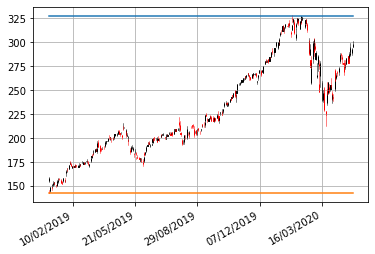

In [15]:
import matplotlib as mpl          #importation de la librairie matplotlib
import matplotlib.pyplot as plt   #importation de la librairie matplotlib.pyplot
import mplfinance as mpf          #importation de la librairie mplfinance
from mplfinance.original_flavor import candlestick_ohlc  #importation de la librairie mplfinance la commande candlestick_ohlc
def draw_graph (ticker, date_debut,date_fin): #création d'une fonction comprenant comme argument (ticker, date_debut,date_fin) puis on séléctionne du tableau candlesticks open_price,close_price,high_price,low_price,date       
    query = '''
      SELECT open_price,close_price,high_price,low_price,date       
      FROM Candlesticks WHERE (ticker IN (\"'''+ticker+"\")"+'''
      AND (date>=\''''+date_debut.strftime("%Y/%m/%d")+"\' AND date<=\'"+date_fin.strftime("%Y/%m/%d")+"\'))"
    PROJET = sqlite3.connect('PROJET.db')
    cursor_PROJET = PROJET.cursor()
    df=pd.read_sql_query(query,PROJET) 
    
    max_value=df[["open_price","close_price"]].max().max()                     #### on assimile à la variable max_value la valeur maximale atteinte durant la période pour chaque ticker       
    min_value=df[["open_price","close_price"]].min().min()                     #### on assimile à la variable min_value la valeur minimale atteinte durant la période pour chaque ticker  
    #####Affichage
    date_format = mpl.dates.DateFormatter('%d/%m/%Y')                          #### on fait en sorte que les dates soient en format jj/MM/AAAA et non en secondes
    df.date=mpl.dates.date2num(pd.to_datetime(df.date))
    df.index=df.date                                                          
    fig, ax_candles = plt.subplots()     #on choisit la forme du graphique qu'on veut avoir                                      
    quot=df[['date','open_price','high_price','low_price','close_price']].values.tolist()                    
    candlestick_ohlc(ax_candles, quotes=quot)        
    ax_candles.plot([df['date'].iloc[0],df['date'].iloc[-1]],[max_value,max_value])     #### commande pour l'afffichage de la courbe contenant la valeur de prix maximale atteinte pour l'action
    ax_candles.plot([df['date'].iloc[0],df['date'].iloc[-1]],[min_value,min_value])     #### commande pour l'afffichage de la courbe contenant la valeur de prix minimale atteinte pour l'action
    ax_candles.autoscale_view()    ##### taille des graphiques    
    ax_candles.grid(True)          ##### 
    ax_candles.xaxis.set_major_formatter(date_format)  
    fig.autofmt_xdate()       
    plt.show() ##### valeur de retour pour la fonction draw_graph
    
draw_graph("AAPL",datetime(2019, 1, 1),datetime.now())    

QUESTION 6:

In [16]:
def add_alert (name, ticker, date_start,date_end,start_value,end_value,source,direction): #création de la fonction avec les arguments
    PROJET = sqlite3.connect('PROJET.db')     #connection avec SQLite3 grâce à la variable projet
    cursor_PROJET = PROJET.cursor()    #création d'une variable contenant le curseur pour la variable projet 
    dir_df=pd.read_sql_query("SELECT * FROM Directions",PROJET)   
    source_df=pd.read_sql_query("SELECT * FROM Sources",PROJET)
    if (not(direction in list(dir_df["direction"])) or not(source in list(source_df["source"]))):
      return #Si les elements source et direction ne correspondent pas a des elements de source ou direction de leurs tableaux,on najoute pas lelement
    
    cursor_PROJET.execute(
                          """INSERT INTO
                                Alerts(name,date_start,date_end,start_value,end_value,source,direction,ticker) 
                                VALUES   (?,?,?,?,?,?,?,?)
                          """,(
                                name,
                                date_start.strftime("%Y/%m/%d"),
                                date_end.strftime("%Y/%m/%d"),
                                str(start_value),
                                str(end_value),
                                source,
                                direction,
                                ticker
                              )
    )
    PROJET.commit()


PROJET = sqlite3.connect('PROJET.db')
cursor_PROJET = PROJET.cursor()
query="SELECT * FROM Alerts"
add_alert("test4","AAPL",datetime(2019,7,9),datetime(2019,12,21),200,260,"open","max")
df=pd.read_sql_query(query,PROJET)
print(df)

    name  date_start    date_end  ...  source  direction ticker
0  test4  2019/07/09  2019/12/21  ...    open        max   AAPL

[1 rows x 8 columns]


QUESTION 7:

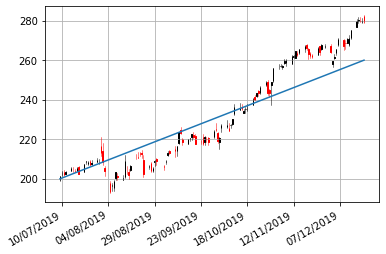

54

In [17]:
def nb_alert(name):
  PROJET = sqlite3.connect('PROJET.db')
  cursor_PROJET = PROJET.cursor()
  
  query="SELECT * FROM Alerts WHERE name=\'"+name+"\'"#importation de alert by name
  alert_df=pd.read_sql_query(query,PROJET)

  query='''SELECT open_price,high_price,low_price,close_price,date FROM Candlesticks
          WHERE (ticker =\"'''+alert_df.ticker[0]+"\" AND (date >=\'"+alert_df.date_start[0]+"\' AND date <=\'"+alert_df.date_end[0]+"\'))"
  df_tick=pd.read_sql_query(query,PROJET)
  slope = (float(alert_df.end_value[0])-float(alert_df.start_value[0]))/df_tick.shape[0]
  equation = lambda t : slope*t+float(alert_df.start_value[0])
  count=0
  for index, row in df_tick.iterrows():
    delta_days = int(index)
    delta_value=equation(delta_days)
    indice=alert_df.source[0]+"_price"
    if(float(row[indice])<delta_value):
      count+=1
  #####PARTIE AFFICHAGE#######
  date_format = mpl.dates.DateFormatter('%d/%m/%Y')
  df_tick.date=mpl.dates.date2num(pd.to_datetime(df_tick.date))
  df_tick.index=df_tick.date
  fig, ax_candles = plt.subplots()
  quot=df_tick[['date','open_price','high_price','low_price','close_price']].values.tolist()
  candlestick_ohlc(ax_candles, quotes=quot) 
  ax_candles.plot([df_tick['date'].iloc[0],df_tick['date'].iloc[-1]],[alert_df.start_value[0],alert_df.end_value[0]])
  ax_candles.autoscale_view()
  ax_candles.grid(True)
  ax_candles.xaxis.set_major_formatter(date_format)
  fig.autofmt_xdate()
  plt.show()
  #######
  return count
nb_alert("test4")

QUESTION 8:

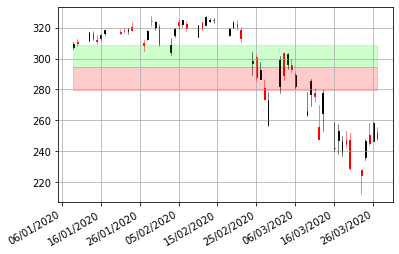

In [39]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplfinance as mpf
import matplotlib.patches as patches
from mplfinance.original_flavor import candlestick_ohlc
def draw_enveloppe(ticker,date_start,date_end,source,pourcentage):
  PROJET = sqlite3.connect('PROJET.db')

  query = "SELECT * FROM Candlesticks WHERE ticker='"+ticker+"' AND date >= '"+date_start.strftime("%Y/%m/%d")+"' AND date <= '"+date_end.strftime("%Y/%m/%d")+"'"
  df=pd.read_sql_query(query,PROJET)
  if source=="open":
    moyenne=df['open_price'].mean()
  elif source=="close":
    moyenne=df['close_price'].mean()
  date_format = mpl.dates.DateFormatter('%d/%m/%Y')               #### on affiche les dates en format JJ/MM/AAAA
  df.date=mpl.dates.date2num(pd.to_datetime(df.date))
  df.index=df.date
    ###Afiichage Candlesticks
  fig, ax = plt.subplots()       
  quot=df[['date','open_price','high_price','low_price','close_price']].values.tolist()
  candlestick_ohlc(ax, quotes=quot)
  

  start = df.date.iloc[0]
  end = df.date.iloc[-1]
  width = end - start
  green_color=(0,1,0,0.2)
  red_color=(1,0,0,0.2)
  rect_up = patches.Rectangle((df.date.iloc[0],moyenne ), width,moyenne*pourcentage , color=green_color)
  rect_down=patches.Rectangle((df.date.iloc[0],moyenne-moyenne*pourcentage ), width,moyenne*pourcentage ,color=red_color)
  ax.add_patch(rect_up)
  ax.add_patch(rect_down)

  ax.xaxis.set_major_formatter(date_format)
  ax.autoscale_view()
  ax.grid(True)
  fig.autofmt_xdate()
  plt.show()

draw_enveloppe("AAPL", datetime(2020,1,9),datetime(2020,3,29), "open", 0.05)


QUESTION 9:

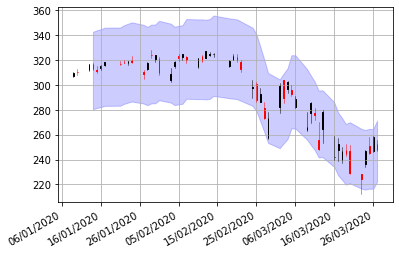

number of days: 55
number of days outside the envelope: 0
number of days inside the envelope: 55


In [62]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplfinance as mpf
import matplotlib.patches as patches
from mplfinance.original_flavor import candlestick_ohlc
def draw_enveloppe_mobile(ticker,date_start,date_end,source,pourcentage):
  PROJET = sqlite3.connect('PROJET.db')

  query = "SELECT * FROM Candlesticks WHERE ticker='"+ticker+"' AND date >= '"+date_start.strftime("%Y/%m/%d")+"' AND date <= '"+date_end.strftime("%Y/%m/%d")+"'"
  df=pd.read_sql_query(query,PROJET)

  date_format = mpl.dates.DateFormatter('%d/%m/%Y')               #### on affiche les dates en format JJ/MM/AAAA
  df.date=mpl.dates.date2num(pd.to_datetime(df.date))
  df.index=df.date
    ###Afiichage Candlesticks
  fig, ax = plt.subplots()       
  quot=df[['date','open_price','high_price','low_price','close_price']].values.tolist()
  candlestick_ohlc(ax, quotes=quot)
  y1=[]
  y2=[]
  indice=source+"_price"
  nb_days_out=0
  nb_days_in=0
  df["moy_mob"]=df.loc[:,indice].rolling(window=4).mean()
  for index,row in df.iterrows():
    y1.append(row["moy_mob"]+pourcentage*row["moy_mob"])
    y2.append(row["moy_mob"]-pourcentage*row["moy_mob"])
    if(row[indice]>row["moy_mob"]+pourcentage*row["moy_mob"]or row[indice]<row["moy_mob"]-pourcentage*row["moy_mob"]):
      nb_days_out+=1
    else:
      nb_days_in+=1
  blue_color=(0,0,1,0.2)
  plt.fill_between(df.date,y1,y2,color=blue_color)

  ax.xaxis.set_major_formatter(date_format)
  ax.autoscale_view()
  ax.grid(True)
  fig.autofmt_xdate()
  plt.show()
  print("number of days: "+str(df.shape[0]))
  print("number of days outside the envelope: "+str(nb_days_out))
  print("number of days inside the envelope: "+str(nb_days_in))

draw_enveloppe_mobile("AAPL", datetime(2020,1,9),datetime(2020,3,29), "open", 0.1)

QUESTION 10:

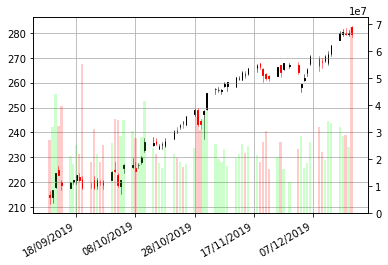

In [40]:
def draw_graph_volume (ticker, date_debut,date_fin):
    query = '''
      SELECT open_price,close_price,high_price,low_price,date,volume
      FROM Candlesticks WHERE (ticker IN (\"'''+ticker+"\")"+'''
      AND (date>=\''''+date_debut.strftime("%Y/%m/%d")+"\' AND date<=\'"+date_fin.strftime("%Y/%m/%d")+"\'))"
    PROJET = sqlite3.connect('PROJET.db')
    cursor_PROJET = PROJET.cursor()
    df=pd.read_sql_query(query,PROJET)
    df.date=mpl.dates.date2num(pd.to_datetime(df.date))
    date_format = mpl.dates.DateFormatter('%d/%m/%Y')
    df.index=df.date 
    fig, ax = plt.subplots()
    quot=df[['date','open_price','high_price','low_price','close_price']].values.tolist()
    candlestick_ohlc(ax, quotes=quot)
    ax.xaxis.set_major_formatter(date_format)
    ax1 = ax.twinx()
    color_list=[]
    green_color=(0,1,0,0.2)
    red_color=(1,0,0,0.2)
    for index,row in df.iterrows():
      if row.open_price> row.close_price:
        color_list.append(red_color)
      else:
        color_list.append(green_color)
    ax1.bar(df.date,df.volume,color=color_list)
    ax.autoscale_view()
    ax.grid(True)
    fig.autofmt_xdate()
    
    plt.show()
draw_graph_volume("AAPL",datetime(2019,9,7),datetime(2019,12,21))

QUESTION 11:

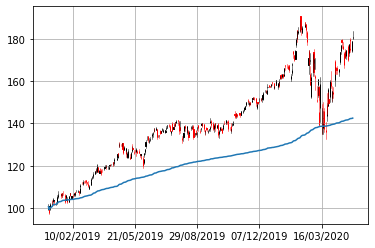

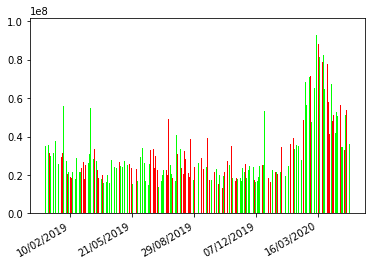

In [41]:
def draw_graph_vwap (ticker):  ###création d'une fonction comprenant comme argument le ticker
 #on sélectionne du tableau candlestick les high_price,low_price,close_price,open_price,volume,date
  query = '''
      SELECT high_price,low_price,close_price,open_price,volume,date
      FROM Candlesticks WHERE ticker IN (\"'''+ticker+"\")"
  PROJET = sqlite3.connect('PROJET.db')
  cursor_PROJET = PROJET.cursor()
  df=pd.read_sql_query(query,PROJET)
  #####Calcul
  sum_vol_mean=0 ####création compteur pour la moyenne du volume initialement nulle
  sum_vol=0      ####création compteur pour le volume initialement nulle
  vwap_list=[]   #### création d'une liste initialement vide

  for index,row in df.iterrows():
    typical_price=(row.high_price+row.low_price+row.close_price)/3            #### on calcule la valeur du typical price pour chaque jour pour chaque ticker
    sum_vol_mean+=typical_price*row.volume                                    #### on cumule à la variable sum_vol_mean la valeur typical*volume pour chaque ticker pour chaque jour
    sum_vol+=row.volume                                                       #### on cumule à la variable sum_vol la somme des volumes pour chaque jour pour chaque ticker
    vwap_list.append(sum_vol_mean/sum_vol)                                    
  df["vwap"]=vwap_list                                                       #### on rajoute au tableau la colonne VWAP contenant les valeurs obtenues dans la liste vwap_list
  #####Affichage
  date_format = mpl.dates.DateFormatter('%d/%m/%Y')               #### on affiche les dates en format JJ/MM/AAAA
  df.date=mpl.dates.date2num(pd.to_datetime(df.date))
  df.index=df.date
    ###Afiichage Candlesticks
  fig, ax_vwap = plt.subplots()       
  quot=df[['date','open_price','high_price','low_price','close_price']].values.tolist()
  candlestick_ohlc(ax_vwap, quotes=quot)
    ###Affichage VWAP
  ax_vwap.plot(df.date,df.vwap)
  ax_vwap.autoscale_view()
  ax_vwap.grid(True)
  ax_vwap.xaxis.set_major_formatter(date_format)
  
    ###Affichage volumes
  fig, ax_vol = plt.subplots()
  color_list=[]
  green_color=(0,1,0,1)
  red_color=(1,0,0,1)
  for index,row in df.iterrows():
    if row.open_price> row.close_price:
      color_list.append(red_color)
    else:
      color_list.append(green_color)
  ax_vol.bar(df.date,df.volume,color=color_list)
  ax_vol.xaxis.set_major_formatter(date_format)
    ###Affichage du tout
  fig.autofmt_xdate()
  plt.show()

draw_graph_vwap("MSFT")
    